# Forecasting

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
import warnings

warnings.filterwarnings("ignore")

# data = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
# data.index = pd.date_range(start='1712', end='2021', freq='A')
# 
# y_hist = data.loc['1986':'2010','SUNACTIVITY']     # size 25
# y_future = data.loc['2011':,'SUNACTIVITY']         # size 10
# 
# h = len(y_hist)
# f = len(y_future)
df_min = pd.read_csv('data/mining.csv')
df_mining = df_min.copy()
df_mining.reset_index(inplace=True)
df_mining.drop(columns=['footnote_codes', 'series_id'], axis=0, inplace=True)


def colums_add_value(raw):
    return f"01-{raw['period'][-2:]}-{str(raw['year'])}"


df_mining['years'] = df_mining.apply(colums_add_value, axis=1)
df_mining.dropna(inplace=True)
df_mining.drop(['year', 'period', 'index'], axis=1, inplace=True)
df_mining = df_mining.query("years.str.startswith('01-01')")
df_mining = df_mining.groupby(['years']).agg('mean')
df_mining.index = pd.to_datetime(df_mining.index)
df_mining.sort_index(inplace=True)
df_mining = df_mining['value']
data=df_mining
y_hist = df_mining.loc[:'2016-01-01']
y_hist.sort_index(inplace=True)
y_future = df_mining.loc['2016-01-01':]
y_future.sort_index(inplace=True)
h = len(y_hist)
f = len(y_future)

In [184]:
data

years
1965-01-01     32.300000
1966-01-01     32.800000
1967-01-01     33.400000
1968-01-01     34.800000
1969-01-01     36.300000
1970-01-01     38.300000
1971-01-01     39.900000
1972-01-01     41.400000
1973-01-01     42.300000
1974-01-01     41.050000
1975-01-01     50.150000
1976-01-01     55.700000
1977-01-01     62.350000
1978-01-01     65.300000
1979-01-01     76.550000
1980-01-01     85.250000
1981-01-01    108.266667
1982-01-01    121.900000
1983-01-01    110.866667
1984-01-01    104.452632
1985-01-01    105.663333
1986-01-01    103.635000
1987-01-01    104.530000
1988-01-01    107.827500
1989-01-01    110.695238
1990-01-01    109.515909
1991-01-01    111.831818
1992-01-01    110.725000
1993-01-01    112.015909
1994-01-01    113.236364
1995-01-01    120.275000
1996-01-01    123.406818
1997-01-01    123.613636
1998-01-01    121.564444
1999-01-01    122.386667
2000-01-01    125.664444
2001-01-01    129.088889
2002-01-01    128.440816
2003-01-01    131.071429
2004-01-01    135.1

### data

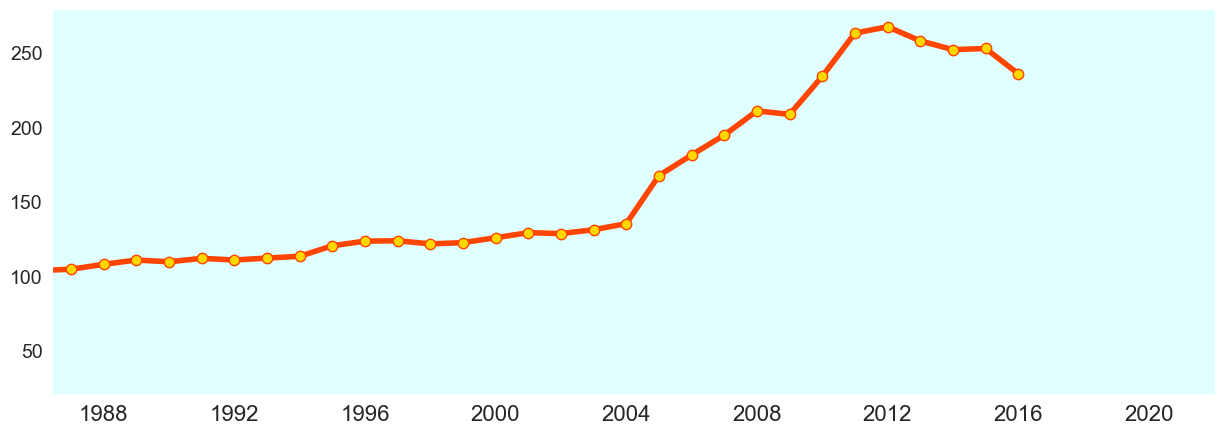

In [185]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot() # nrows, ncols, index
ax.set_facecolor('lightcyan')

plt.plot(y_hist,'.-',
         markerfacecolor='gold',
         markersize=15,
         linewidth=4,
         color='orangered')

plt.grid()
plt.ylabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=16)
plt.xlim((6000, 19000))

myylim = plt.ylim()

### train a model

In [186]:
period = 2
res = seasonal_decompose(data,period=period,extrapolate_trend=True)

print(res.trend.size)
print(res.seasonal.size)

59
59


### make a forecast

In [187]:
y_forecast = res.trend
y_forecast = pd.concat([y_forecast,y_future])
y_forecast[-f:] = np.NaN

y_forecast.interpolate(method='linear',inplace=True)

y_forecast = y_forecast[-f:]
y_forecast = y_forecast + res.seasonal[y_forecast.index - pd.DateOffset(years=period)].values

In [188]:
y_future['2011-12-31'] = 135.0
y_future['2014-12-31'] = 81.0
y_future['2020-12-31'] = 45.0

### plot

ValueError: operands could not be broadcast together with shapes (8,) (11,) 

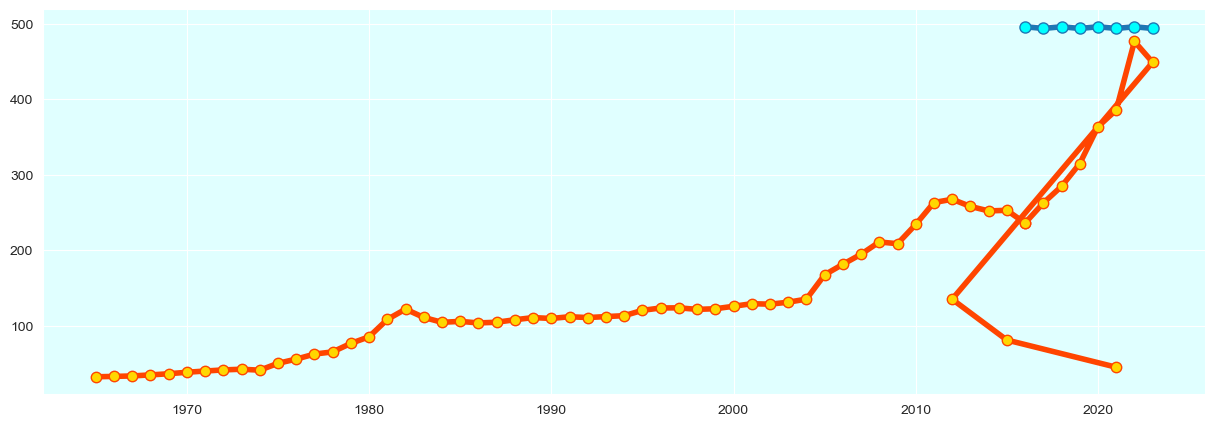

In [189]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot() # nrows, ncols, index
ax.set_facecolor('lightcyan')

plt.plot(y_hist,'.-',
         markerfacecolor='gold',
         markersize=15,
         linewidth=4,
         color='orangered')

plt.plot(y_future,'.-',
         markerfacecolor='gold',
         markersize=15,
         linewidth=4,
         color='orangered')

plt.plot(y_forecast,'.-',
         linewidth=4,marker='o',
         markerfacecolor='cyan',
         markersize=8)

plt.fill_between(y_forecast.index, y_forecast, y_future,color=(0.6,0.6,0.6))

plt.grid()
# ax.get_yaxis().set_visible(False)
plt.yticks(fontsize=14)
plt.xticks(fontsize=16)
plt.xlim((6000, 19000))
plt.ylim(myylim)

### evaluate error

In [ ]:
forecast_error = y_future - y_forecast
e1 = forecast_error.abs().mean()
e2 = np.sqrt( forecast_error.pow(2).mean() )

print(e1, e2)

# Simple forecasting

In [190]:
ar=[0.4,0.1]
ma=[0.9,0.4]
f= 10
h= 100

z = arma_generate_sample(ar, ma, h)
time = np.linspace(0,h-1,h)
d = 10*np.cos(33 + time/10)
y_hist = z + d

time_pred = np.linspace(h,h+f,f)
y_forecast_const = np.full(f,y_hist[-1])
y_forecast_firstorder = y_hist[-1] + np.mean(np.diff(y_hist[-10:]))*(time_pred - h) 

Text(0.5, 0, 'time')

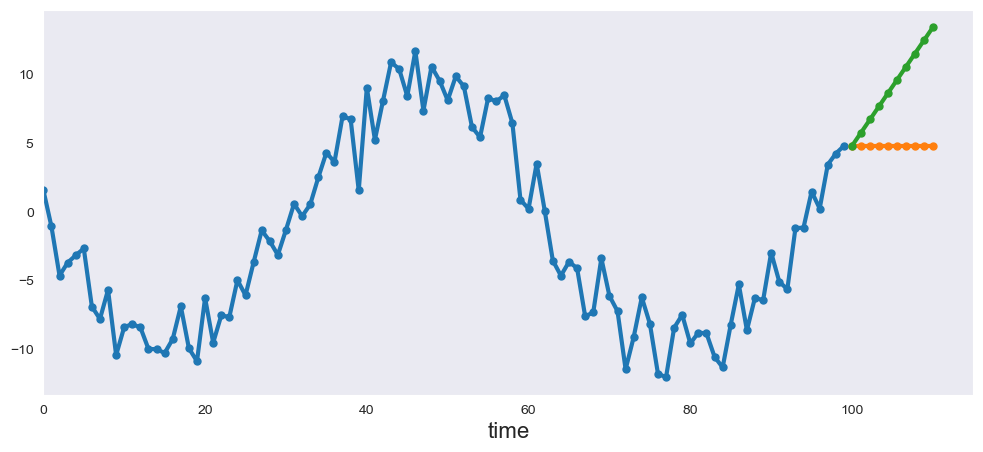

In [191]:
plt.figure(figsize=(12,5))
plt.plot(time,y_hist,
         '.-',
         markersize=10,
         linewidth=3)

plt.plot(time_pred,y_forecast_const,'.-',
         markersize=10,
         linewidth=3)

plt.plot(time_pred,y_forecast_firstorder, '.-',
         markersize=10,
         linewidth=3)
plt.xlim([0,115])
plt.grid()
plt.xlabel('time',fontsize=16)